# LSTM - Long Short Term Memory Neural Network

Surgen de la necesidad de conservar información de más tiempo atrás, en redes recurrentes, la información se puede desvanecer tras pocas iteraciones, ya que en el cálculo del gradiente de la capa oculta (en RNN's convencionales) se escala según el gradiente de iteraciones anteriores, desvaneciendo el gradiente en varias iteraciones o, en caso contrario, creciendo de forma exponencial y causando divergencia en el modelo.

La arquitectura de una neurona utilizada en LSTM, llamada $\textit{célula}$, cuenta con combinaciones de compuertas con una respectiva función de activación:

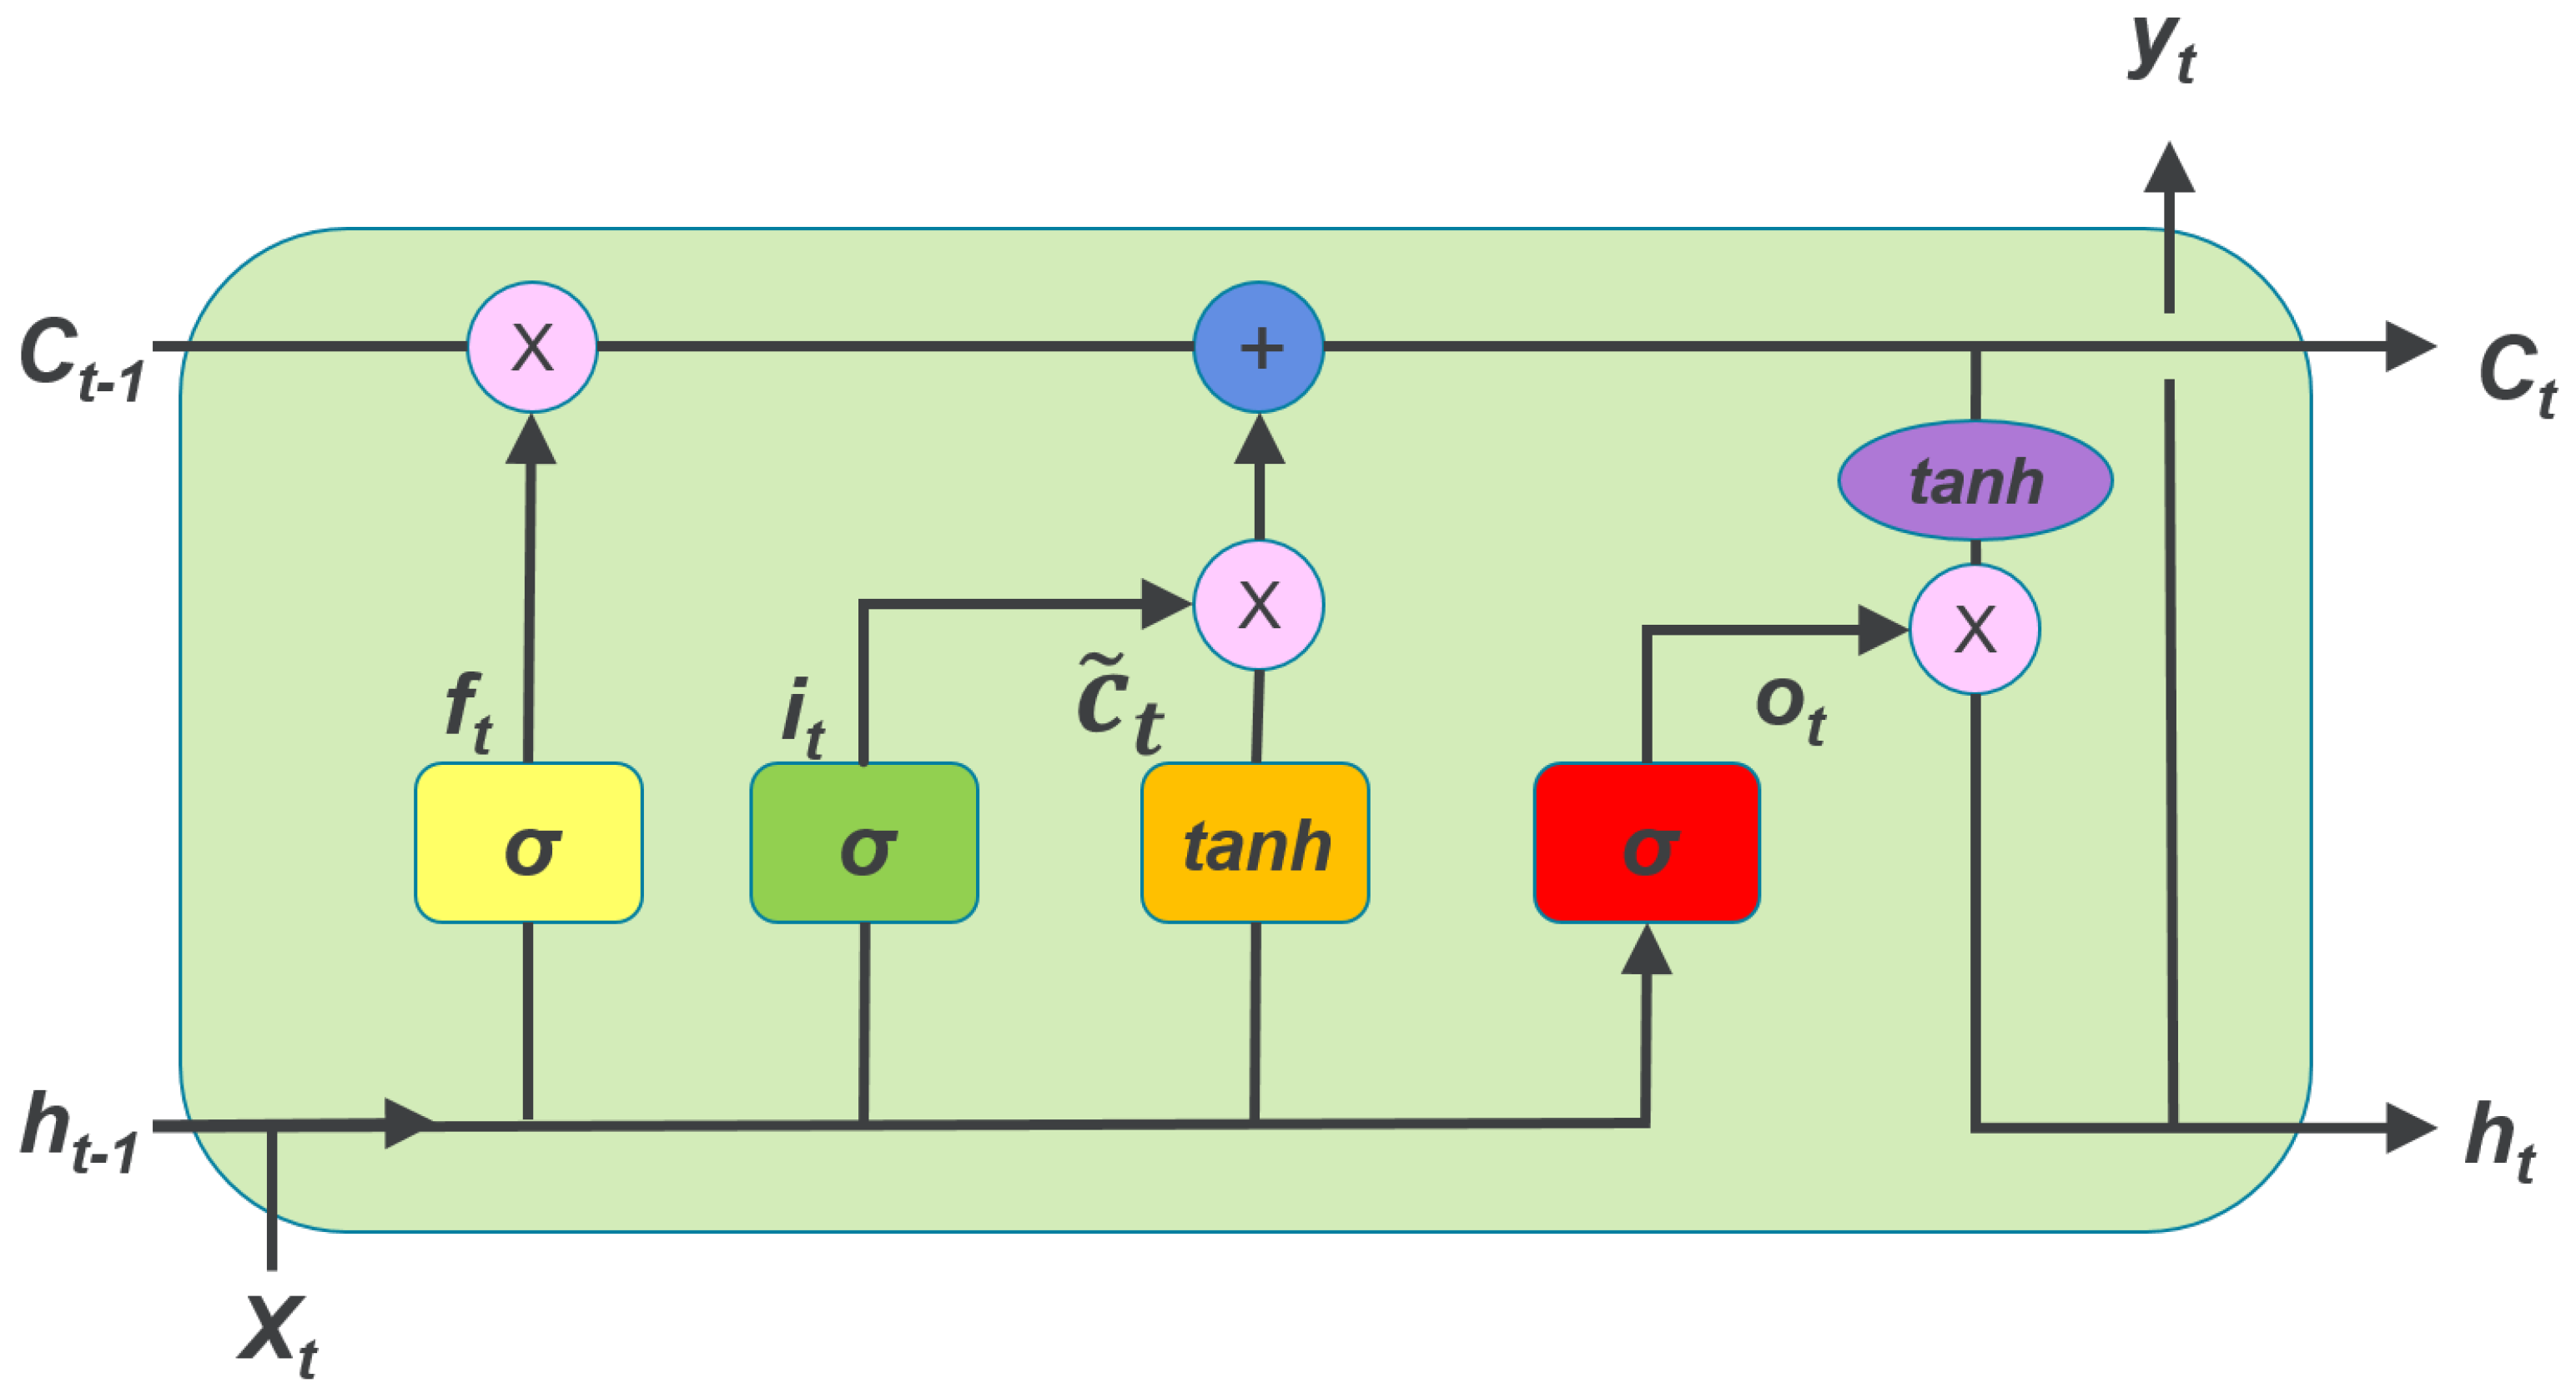

In [2]:
from IPython.display import Image
Image(filename='img/LSTM_Cell.png', width=800)

La entrada actual $X_t$ y la información de la salida de la capa oculta del tiempo anterior $h_{t-1}$ pasan por varios perceptrones con función de activación sigmoide (gates) y uno de tangente hiperbólica.

$f_t$ determina si la neurona "olvida" o no la información al multiplicarse con el estado anterior $C_{t-1}$, mientras que $i_t$ define si la información del dato candidato $\tilde{C}_t$ debe combinarse con la información del estado anterior, esto produce el nuevo estado $C_t$.

Finalmente, la compuerta $o_t$ pondera cuánta información de este proceso es transmitida a la salida de la red neuronal $y_t$ y se utiliza además como información de la capa oculta actual $h_t$ para ser utilizada en la siguiente observación.

El proceso de esta célula se basa en un filtro móvil exponencial de la forma $\mu^t \leftarrow \beta\mu^{(t-1)}+(1-\beta)v^{(t)}$, ponderado por el parámetro $\beta$ que determinará la importancia del dato pasado ($t=t-1$) de manera inversamente proporcional al dato actual ($t$).

In [118]:
#Se define una función cualquiera y se le agrega ruido
x = np.arange(0, 3, 0.01)
y = np.sin(2*np.pi*x)
y += np.random.rand(x.size)

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
np.random.seed(666)

@interact(Beta = (0., 1., 0.1))

def plotGraph(Beta):
    # global x, y
    plt.figure(figsize=(10,6))
    plt.plot(x, y, 'b', alpha=0.5, label="Original")

    #Se define una copia de la función y se le aplica un filtro móvil exponencial
    y2 = np.copy(y)
    for i in range(1, x.size): 
        y2[i] = Beta * y2[i-1] + (1 - Beta) * y[i]

    plotLabel="Beta = " + str(Beta)
    
    plt.plot(x, y2, 'r', alpha= 0.5, label=plotLabel)
    plt.legend(loc=2)
    plt.grid()
    plt.show()




interactive(children=(FloatSlider(value=0.5, description='Beta', max=1.0), Output()), _dom_classes=('widget-in…

## Aplcación de LSTM a un conjunto de datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
import math
from sklearn.metrics import mean_squared_error